In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
PATH = "data/dogscats/"
batch_size = 1
t_model_path = PATH+'models/224_all.h5'
t_model_name = '224_all'
sz=224
bs=1

In [6]:
import io
import numpy as np

from torch import nn
from torch.autograd import Variable
import torch.utils.model_zoo as model_zoo
import torch.onnx

In [7]:
arch=resnet34
tfms_data=tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data=ImageClassifierData.from_paths(PATH,tfms=tfms_data)
learn=ConvLearner.pretrained(arch, data, precompute=False)
learn.load(t_model_name)

In [8]:
torch_model = learn.model

torch_model.train(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [9]:
class ConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AvgPool2d(sz)
        self.mp = nn.MaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

data/dogscats/valid/dogs/dog.8088.jpg


array([ 0.00614,  0.99386], dtype=float32)

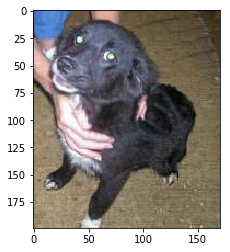

In [18]:
def predictByFile(fileName):
    
    _, val_tfms = tfms_from_model(arch, sz)
    source_img = open_image(fileName)  
    print(fileName)
    plt.imshow(source_img)
    img = val_tfms(source_img)
    preds = learn.predict_array(img[None])
    #print(img)
    return np.exp(preds[0])
fileName = data.val_ds.fnames[1170]
predictByFile(PATH+fileName)

In [19]:
def getImg(fileName):
    _, val_tfms = tfms_from_model(arch, sz)
    source_img = open_image(fileName)  
    print(fileName)
    plt.imshow(source_img)
    img = val_tfms(source_img)
    return img[None]

data/dogscats/valid/dogs/dog.8088.jpg


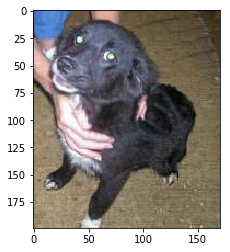

In [23]:
tx = getImg(PATH+fileName)

In [10]:
torch.save(torch_model, PATH+'dogs-cats-torch-model.pt')

In [11]:
tm = torch.load(PATH+'dogs-cats-torch-model.pt', map_location=lambda storage, loc: storage)

In [35]:
tm.train(False)
output = tm(x.cpu())
np.exp(output.cpu().data.numpy())

array([[ 0.00614,  0.99386]], dtype=float32)

In [31]:
x = Variable(torch.from_numpy(tx), requires_grad=True)
output = torch_model(x.cuda())
np.exp(output.cpu().data.numpy())

array([[ 0.00614,  0.99386]], dtype=float32)

In [11]:
torch_model(x)

Variable containing:
-0.9162 -0.5109
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]

In [12]:
torch_model.add_module('8', ConcatPool2d(7))
torch_model(x)

Variable containing:
-0.9162 -0.5109
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]

In [13]:
x = Variable(torch.randn(bs, 3, sz, sz).cuda(), requires_grad=True)

# Export the model
torch_out = torch.onnx._export(torch_model,             # model being run
                               x,                       # model input (or a tuple for multiple inputs)
                               PATH + "dogs-cats.onnx", # where to save the model (can be a file or file-like object)
                               export_params=True)      # store the trained parameter weights inside the model file

In [ ]:
x.data.cpu().numpy().shape

In [ ]:
import onnx
import caffe2.python.onnx.backend

# Prepare the inputs, here we use numpy to generate some random inputs for demo purpose
import numpy as np
img = np.random.randn(1, 3, 224, 224).astype(np.float32)

# Load the ONNX model
model = onnx.load(PATH + "dogs-cats.onnx")
# Run the ONNX model with Caffe2
outputs = caffe2.python.onnx.backend.run_model(model, [img])
outputs

In [16]:
import onnx
import caffe2.python.onnx.backend

# Load the ONNX ModelProto object. model is a standard Python protobuf object
model = onnx.load(PATH + "dogs-cats.onnx")

# prepare the caffe2 backend for executing the model this converts the ONNX model into a
# Caffe2 NetDef that can execute it. Other ONNX backends, like one for CNTK will be
# availiable soon.
prepared_backend = caffe2.python.onnx.backend.prepare(model)

# run the model in Caffe2

# Construct a map from input names to Tensor data.
# The graph of the model itself contains inputs for all weight parameters, after the input image.
# Since the weights are already embedded, we just need to pass the input image.
# Set the first input.
W = {model.graph.input[0].name: x.cpu().data.numpy()}

# Run the Caffe2 net:
c2_out = prepared_backend.run(W)[0]

# Verify the numerical correctness upto 3 decimal places
np.testing.assert_almost_equal(torch_out.data.cpu().numpy(), c2_out, decimal=3)

print("Exported model has been executed on Caffe2 backend, and the result looks good!")

Original python traceback for operator 126 in network `torch-jit-export_predict` in exception above (most recent call last):


RuntimeError: [enforce fail at spatial_batch_norm_op.cc:11] X.ndim() >= 3 && X.ndim() <= 5.  Error from operator: 
input: "391" input: "182" input: "183" input: "184" input: "185" output: "393" name: "" type: "SpatialBN" arg { name: "momentum" f: 0.9 } arg { name: "is_test" i: 1 } arg { name: "epsilon" f: 1e-05 } device_option { device_type: 0 cuda_gpu_id: 0 }

In [ ]:
model